# 🧠 Reasoning LoRA with Self-Rewarding GRPO

## Ellora Recipe #2: Chain-of-Thought Reasoning Enhancement

This notebook implements a reasoning LoRA adapter that teaches models to use structured thinking patterns with `<think></think>` tags using Group Relative Policy Optimization (GRPO) and self-generated preference data.

**Key Innovation:** Instead of external reasoning datasets, we generate diverse reasoning problems and train the model to prefer responses with clear, structured thinking using GRPO's preference-based approach.

### Architecture:
- **Base Model:** google/gemma-3-1b-it (or configurable)
- **Training Method:** GRPO (Group Relative Policy Optimization)
- **Training Data:** Self-generated reasoning problems using Magpie approach
- **Objective:** Learn to use `<think></think>` tags for structured reasoning
- **Output Format:** Enhanced chain-of-thought capabilities

## 📦 Setup and Installation

In [1]:
# Install required packages
!pip install -q "transformers>=4.36.0"
!pip install -q "peft>=0.7.0"
!pip install -q "bitsandbytes>=0.41.0"
!pip install -q "accelerate>=0.24.0"
!pip install -q "datasets>=3.14.0"
!pip install -q "torch>=2.0.0"
!pip install -q matplotlib seaborn
!pip install -q tqdm
!pip install -q huggingface_hub
!pip install -q numpy
!pip install -q scipy
!pip install -q scikit-learn
!pip install -q vllm


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new 

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer
)
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import Dataset
from tqdm.auto import tqdm
import json
import time
import re
import random
from typing import List, Dict, Tuple, Optional
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch version: 2.7.0+cu126
CUDA available: True
GPU: NVIDIA L4
CUDA memory: 23.6 GB


## ⚙️ Configuration

In [3]:
# Experiment Configuration
CONFIG = {
    # Model settings
    "model_name": "google/gemma-3-1b-it",  # Changed to gemma as requested
    "cache_dir": "./models",

    # Data generation (Magpie + Reasoning)
    "num_train_samples": 1000,  # Reduce for Colab but enough for reasoning
    "num_eval_samples": 200,
    "max_query_length": 1024,
    "max_response_length": 2048,
    "generation_temperature": 0.6,
    "responses_per_prompt": 4,  # Generate multiple responses for ranking

    # LoRA configuration
    "lora_r": 64,  # Higher rank for reasoning capabilities
    "lora_alpha": 128,
    "lora_dropout": 0.2,
    "target_modules": ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],

    # GRPO training settings
    "batch_size": 1,  # Smaller due to longer sequences
    "gradient_accumulation_steps": 4,
    "max_grad_norm": 1.0,  # Add gradient clipping
    "learning_rate" : 1e-5,
    "num_epochs": 2,
    "warmup_ratio": 0.1,
    "weight_decay": 0.05,

    # GRPO specific settings
    "grpo_beta": 0.01,  # KL penalty
    "grpo_alpha": 1.0,  # Preference strength
    "max_length": 1024,

    # Reasoning evaluation settings
    "eval_steps": 50,
    "save_steps": 20,
    "logging_steps": 10,

    # Thinking tag settings
    "think_tag_start": "<think>",
    "think_tag_end": "</think>",
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  model_name: google/gemma-3-1b-it
  cache_dir: ./models
  num_train_samples: 1000
  num_eval_samples: 200
  max_query_length: 1024
  max_response_length: 2048
  generation_temperature: 0.6
  responses_per_prompt: 4
  lora_r: 64
  lora_alpha: 128
  lora_dropout: 0.2
  target_modules: ['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj']
  batch_size: 1
  gradient_accumulation_steps: 4
  max_grad_norm: 1.0
  learning_rate: 1e-05
  num_epochs: 2
  warmup_ratio: 0.1
  weight_decay: 0.05
  grpo_beta: 0.01
  grpo_alpha: 1.0
  max_length: 1024
  eval_steps: 50
  save_steps: 20
  logging_steps: 10
  think_tag_start: <think>
  think_tag_end: </think>


## 🔐 HuggingFace Authentication

In [4]:
# HuggingFace Hub Authentication
from huggingface_hub import login

# Option 1: Interactive login (recommended)
login()

# Option 2: Login with token
# login(token='your_hf_token_here')

print("✅ Authentication setup complete!")
print("💡 Tip: If you don't authenticate, the notebook will still work but won't upload datasets to HF Hub")

✅ Authentication setup complete!
💡 Tip: If you don't authenticate, the notebook will still work but won't upload datasets to HF Hub


## 🤖 Model Loading

In [5]:
def load_base_model(model_name: str, cache_dir: str):
    """Load the base model in FP16 precision."""
    print(f"📚 Loading base model: {model_name}...")

    tokenizer = AutoTokenizer.from_pretrained(
        model_name,
        cache_dir=cache_dir,
        trust_remote_code=True
    )

    # Ensure we have a pad token
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        attn_implementation='eager',
        torch_dtype=torch.float16,
        device_map="auto",
        cache_dir=cache_dir,
        trust_remote_code=True
    )

    print(f"✅ Base model loaded: {model.num_parameters():,} parameters")
    return model, tokenizer

def load_training_model(model_name: str, cache_dir: str, lora_config: LoraConfig):
    """Load the training model with quantization and LoRA."""
    print("🎓 Loading training model (INT4 + LoRA)...")

    # 4-bit quantization config for training efficiency
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4"
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        attn_implementation='eager',
        quantization_config=quantization_config,
        device_map="auto",
        cache_dir=cache_dir,
        trust_remote_code=True
    )

    # Add LoRA adapter
    model = get_peft_model(model, lora_config)
    model.print_trainable_parameters()

    print("✅ Training model loaded with LoRA adapter")
    return model

# Load models
base_model, tokenizer = load_base_model(CONFIG["model_name"], CONFIG["cache_dir"])

# LoRA configuration optimized for reasoning
lora_config = LoraConfig(
    r=CONFIG["lora_r"],
    lora_alpha=CONFIG["lora_alpha"],
    target_modules=CONFIG["target_modules"],
    lora_dropout=CONFIG["lora_dropout"],
    bias="none",
    task_type="CAUSAL_LM"
)

training_model = load_training_model(CONFIG["model_name"], CONFIG["cache_dir"], lora_config)

print(f"\n🧠 Memory usage:")
if torch.cuda.is_available():
    print(f"  GPU memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"  GPU memory cached: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

📚 Loading base model: google/gemma-3-1b-it...
✅ Base model loaded: 999,885,952 parameters
🎓 Loading training model (INT4 + LoRA)...
trainable params: 52,183,040 || all params: 1,052,068,992 || trainable%: 4.9600
✅ Training model loaded with LoRA adapter

🧠 Memory usage:
  GPU memory allocated: 3.17 GB
  GPU memory cached: 4.34 GB


## 🧩 Reasoning Data Generation with Magpie

We generate reasoning problems that benefit from structured thinking and create preference data for GRPO training.

In [6]:
class ReasoningDataGenerator:
    """Generates reasoning data using Magpie approach with vLLM for efficient generation."""

    def __init__(self, model, tokenizer, config: dict):
        self.tokenizer = tokenizer  # Keep for validation only
        self.config = config
        
        # Setup vLLM for efficient generation
        self.vllm_model = None
        self._setup_vllm()

        # Reasoning prompt templates that encourage thinking
        self.reasoning_domains = [
            "mathematics", "logic puzzles", "science", "programming",
            "philosophy", "ethics", "problem solving", "analysis",
            "planning", "decision making", "critical thinking", "strategy"
        ]

        # Create dataset name
        model_name = config["model_name"].split("/")[-1]
        self.dataset_name = f"codelion/{model_name}-magpie-reasoning"
        
        # Memory and generation monitoring
        self.generation_count = 0
        
        print(f"✅ ReasoningDataGenerator initialized with vLLM")
        print(f"📊 Config: {config['num_train_samples']} train, {config['num_eval_samples']} eval samples")
        print(f"🔧 Generation: Enhanced quality-aware generation (6 responses per prompt)")

    def _setup_vllm(self):
        """Setup vLLM for efficient generation."""
        try:
            from vllm import LLM, SamplingParams
            print("🚀 Setting up vLLM for efficient generation...")
            
            self.vllm_model = LLM(
                model=self.config["model_name"],
                tensor_parallel_size=1,
                gpu_memory_utilization=0.6,
                max_model_len=self.config["max_length"],
                trust_remote_code=True,
                disable_log_stats=True
            )
            
            # Sampling parameters from config
            self.vllm_sampling_params = SamplingParams(
                temperature=self.config["generation_temperature"],
                max_tokens=self.config["max_response_length"],
                repetition_penalty=1.1,
                stop=[self.tokenizer.eos_token] if hasattr(self.tokenizer, 'eos_token') else None
            )
            
            print("✅ vLLM setup complete!")
            
        except ImportError:
            raise ImportError("vLLM not installed. Install with: pip install vllm")
        except Exception as e:
            raise RuntimeError(f"vLLM setup failed: {e}")

    def _generate_batch(self, prompts: List[str]) -> List[str]:
        """Generate responses using vLLM batch processing."""
        try:
            outputs = self.vllm_model.generate(prompts, self.vllm_sampling_params)
            responses = [output.outputs[0].text.strip() for output in outputs]
            return responses
        except Exception as e:
            print(f"❌ vLLM generation failed: {e}")
            return ["Generation failed"] * len(prompts)

    def _monitor_memory(self, step_name: str = ""):
        """Monitor generation progress."""
        self.generation_count += 1
        if self.generation_count % 50 == 0:
            print(f"📊 Generated {self.generation_count} samples at {step_name}")

    def cleanup_vllm(self):
        """Clean up vLLM model to free GPU memory."""
        if self.vllm_model is not None:
            print("🧹 Cleaning up vLLM model from data generation...")
            try:
                del self.vllm_model
                self.vllm_model = None
                
                import gc
                gc.collect()
                torch.cuda.empty_cache()
                
                print("✅ vLLM model cleaned up successfully")
                
                if torch.cuda.is_available():
                    allocated = torch.cuda.memory_allocated() / 1e9
                    cached = torch.cuda.memory_reserved() / 1e9
                    print(f"💾 GPU memory after cleanup: {allocated:.2f}GB allocated, {cached:.2f}GB cached")
                    
            except Exception as e:
                print(f"❌ Error during vLLM cleanup: {e}")
        else:
            print("ℹ️ No vLLM model to clean up")

    def dataset_exists_on_hf(self) -> bool:
        """Check if the dataset already exists on Hugging Face Hub."""
        try:
            from huggingface_hub import dataset_info
            dataset_info(self.dataset_name)
            return True
        except Exception:
            return False

    def load_existing_dataset(self) -> Tuple[Optional[List[Dict]], Optional[List[Dict]]]:
        """Load existing dataset from Hugging Face Hub."""
        print(f"📥 Loading existing dataset from HF Hub: {self.dataset_name}")

        try:
            from datasets import load_dataset
            dataset = load_dataset(self.dataset_name)

            train_data = [dict(item) for item in dataset["train"]]
            eval_data = [dict(item) for item in dataset["validation"]]

            print(f"✅ Successfully loaded dataset:")
            print(f"  Training samples: {len(train_data)}")
            print(f"  Evaluation samples: {len(eval_data)}")

            return train_data, eval_data

        except Exception as e:
            print(f"❌ Error loading dataset: {e}")
            print("🔄 Will generate new dataset instead...")
            return None, None

    def push_dataset_to_hf(self, train_data: List[Dict], eval_data: List[Dict]):
        """Push the generated dataset to Hugging Face Hub."""
        print(f"📤 Pushing dataset to HF Hub: {self.dataset_name}")

        try:
            from datasets import Dataset, DatasetDict

            train_dataset = Dataset.from_list(train_data)
            eval_dataset = Dataset.from_list(eval_data)

            dataset_dict = DatasetDict({
                "train": train_dataset,
                "validation": eval_dataset
            })

            dataset_dict.push_to_hub(
                self.dataset_name,
                private=False
            )

            print(f"✅ Dataset successfully pushed to: https://huggingface.co/datasets/{self.dataset_name}")

        except Exception as e:
            print(f"❌ Error pushing dataset to HF Hub: {e}")
            print("💾 Dataset generation completed but not uploaded to HF Hub")

    def generate_reasoning_prompts_batch(self, batch_size: int) -> List[str]:
        """Generate a batch of reasoning prompts using vLLM."""
        domains = random.choices(self.reasoning_domains, k=batch_size)
        
        # Domain-specific prompt templates
        prompts_by_domain = {
            "mathematics": [
                "Solve this step by step:",
                "Find the solution and explain your reasoning:",
                "Calculate the following and show your work:",
            ],
            "logic puzzles": [
                "Solve this logic puzzle:",
                "Figure out the answer to this riddle:",
                "Reason through this step by step:",
            ],
            "science": [
                "Explain the scientific principle behind:",
                "Analyze this scientific scenario:",
                "Predict what would happen and explain why:",
            ],
            "programming": [
                "Debug this code and explain the issue:",
                "Design an algorithm for:",
                "Optimize this solution:",
            ],
            "philosophy": [
                "Analyze this philosophical question:",
                "Consider the ethical implications of:",
                "Examine this moral dilemma:",
            ]
        }
        
        meta_prompts = []
        for domain in domains:
            base_prompt = random.choice(prompts_by_domain.get(domain, ["Analyze and explain:"]))
            meta_prompt = f"Generate a {domain} problem that requires step-by-step reasoning. Start with '{base_prompt}'"
            meta_prompts.append(meta_prompt)
        
        # Generate batch of problems
        generated_responses = self._generate_batch(meta_prompts)
        
        # Extract problems from responses
        problems = []
        for i, (meta_prompt, generated) in enumerate(zip(meta_prompts, generated_responses)):
            if meta_prompt in generated:
                problem = generated[len(meta_prompt):].strip()
            else:
                problem = generated.strip()
            
            # Fallback if generation failed
            if len(problem) < 10:
                domain = domains[i]
                base_prompt = random.choice(prompts_by_domain.get(domain, ["Analyze and explain:"]))
                problem = f"{base_prompt} a {domain} problem that requires reasoning."
            
            problems.append(problem)
        
        return problems

    def _assess_raw_quality(self, response: str) -> float:
        """Assess response quality WITHOUT thinking tag bias."""
        score = 0.0
        
        # Length and completeness
        word_count = len(response.split())
        if word_count >= 50:
            score += 3.0
        elif word_count >= 30:
            score += 2.0
        elif word_count >= 15:
            score += 1.0
        
        # Reasoning indicators (regardless of thinking tags)
        reasoning_words = [
            "because", "therefore", "since", "thus", "hence",
            "step", "first", "second", "next", "then", "finally",
            "analyze", "consider", "examine", "evaluate"
        ]
        reasoning_count = sum(1 for word in reasoning_words if word in response.lower())
        score += min(reasoning_count * 0.4, 3.0)
        
        # Structure and coherence
        structure_phrases = [
            "step by step", "first", "second", "in conclusion",
            "let me", "we can", "the answer is", "to solve this"
        ]
        structure_count = sum(1 for phrase in structure_phrases if phrase in response.lower())
        score += min(structure_count * 0.5, 2.0)
        
        # Mathematical/logical content
        if any(char in response for char in "=+-*/()[]{}|"):
            score += 1.5
        
        # Avoid very repetitive text
        words = response.lower().split()
        if len(words) > 5:
            unique_ratio = len(set(words)) / len(words)
            if unique_ratio < 0.3:  # Very repetitive
                score -= 2.0
            elif unique_ratio > 0.7:  # Good diversity
                score += 1.0
        
        # Ensure reasonable range
        return max(0.0, min(10.0, score))

    def generate_responses_batch(self, problems: List[str]) -> List[List[str]]:
        """Generate responses ensuring thinking responses are actually better quality."""
        all_prompts = []
        problem_indices = []
        prompt_types = []
        
        for prob_idx, problem in enumerate(problems):
            # Generate 6 responses: 3 thinking + 3 non-thinking for better selection
            for resp_idx in range(6):
                if resp_idx < 3:  # First 3 are thinking responses
                    prompt_type = "thinking"
                    
                    full_prompt = f"""Think step by step and use {self.config["think_tag_start"]}{self.config["think_tag_end"]} tags to show your reasoning process.\n\nProblem: {problem}\n\nResponse:"""
                
                else:  # Last 3 are non-thinking responses
                    prompt_type = "non_thinking"
                    
                    full_prompt = f"Problem: {problem}\n\nResponse:"
                
                all_prompts.append(full_prompt)
                problem_indices.append(prob_idx)
                prompt_types.append(prompt_type)
        
        # Generate all responses at once
        print(f"🚀 Generating {len(all_prompts)} responses in batch (quality-aware)...")
        all_responses = self._generate_batch(all_prompts)
        
        # Group responses by problem and type
        responses_by_problem = [{"thinking": [], "non_thinking": []} for _ in problems]
        
        for i, (response, prob_idx, prompt_type) in enumerate(zip(all_responses, problem_indices, prompt_types)):
            # Clean up response
            if ":" in response:
                if prompt_type == "thinking" and "tags:" in response:
                    response = response.split("tags:")[-1].strip()
                elif prompt_type == "non_thinking" and "answer:" in response:
                    response = response.split("answer:")[-1].strip()
            
            # Assess raw quality
            raw_quality = self._assess_raw_quality(response)
            
            responses_by_problem[prob_idx][prompt_type].append({
                "response": response,
                "raw_quality": raw_quality
            })
        
        # Select best thinking + worst non-thinking for clear preference pairs
        final_responses_by_problem = []
        
        for prob_responses in responses_by_problem:
            thinking_responses = prob_responses["thinking"]
            non_thinking_responses = prob_responses["non_thinking"]
            
            selected_responses = []
            
            # Pick best thinking response (highest quality)
            if thinking_responses:
                best_thinking = max(thinking_responses, key=lambda x: x["raw_quality"])
                selected_responses.append(best_thinking["response"])
            
            # Pick worst non-thinking response (lowest quality)
            if non_thinking_responses:
                worst_non_thinking = min(non_thinking_responses, key=lambda x: x["raw_quality"])
                selected_responses.append(worst_non_thinking["response"])
            
            # If we don't have both types, pick from available ones
            if len(selected_responses) < 2:
                all_available = thinking_responses + non_thinking_responses
                if len(all_available) >= 2:
                    # Sort by quality and pick best and worst
                    sorted_responses = sorted(all_available, key=lambda x: x["raw_quality"], reverse=True)
                    selected_responses = [sorted_responses[0]["response"], sorted_responses[-1]["response"]]
            
            final_responses_by_problem.append(selected_responses)
        
        return final_responses_by_problem

    def score_reasoning_quality(self, response: str) -> float:
        """Score the quality of reasoning in a response with thinking tag emphasis."""
        score = 0.0
        
        # Use config for thinking tags
        think_start = self.config["think_tag_start"]
        think_end = self.config["think_tag_end"]

        # Moderate bonus for thinking tags (not overwhelming)
        has_think_tags = think_start in response and think_end in response
        if has_think_tags:
            score += 5.0  # Reduced from 10.0 to be less dominant
            
            # Extract thinking content
            import re
            think_pattern = f'{re.escape(think_start)}(.*?){re.escape(think_end)}'
            think_matches = re.findall(think_pattern, response, re.DOTALL)

            if think_matches:
                think_content = ' '.join(think_matches)
                think_words = think_content.split()
                
                # Quality bonuses for thinking content
                if len(think_words) > 20:
                    score += 2.0
                elif len(think_words) > 10:
                    score += 1.0
                
                # Reasoning pattern bonuses
                if any(word in think_content.lower() for word in ["because", "therefore", "since", "thus", "hence"]):
                    score += 1.0
                if any(word in think_content.lower() for word in ["step", "first", "next", "then", "finally"]):
                    score += 1.0
                if any(word in think_content.lower() for word in ["analyze", "consider", "examine", "evaluate"]):
                    score += 1.0
        else:
            # Smaller penalty for no thinking tags
            score -= 2.0  # Reduced from -5.0

        # Give more weight to actual reasoning quality
        reasoning_markers = [
            "step by step", "first", "second", "third", "because", "therefore",
            "since", "thus", "hence", "let me think", "reasoning", "analysis"
        ]

        for marker in reasoning_markers:
            if marker in response.lower():
                score += 0.3  # Increased from 0.1

        # Mathematical/logical structure
        if any(char in response for char in "=+-*/()[]{}|"):
            score += 0.5

        # Length bonuses/penalties
        word_count = len(response.split())
        if word_count < 15:
            score -= 1.0
        elif word_count > 30:
            score += 1.0

        # Ensure reasonable range
        return max(-2.0, score)

    def generate_preference_data(self, num_samples: int, split: str = "train") -> List[Dict]:
        """Generate preference data with quality-aware selection."""
        print(f"🧠 Generating {num_samples} {split} reasoning samples with quality-aware preferences...")
        print(f"🎯 Strategy: Best thinking responses vs worst non-thinking responses")

        dataset = []
        
        # Process in batches for efficiency
        batch_size = 8  # Reduced since we're generating 6 responses per problem
        
        for batch_start in tqdm(range(0, num_samples, batch_size), desc=f"Generating {split} data"):
            batch_end = min(batch_start + batch_size, num_samples)
            current_batch_size = batch_end - batch_start
            
            try:
                # Step 1: Generate batch of reasoning problems
                problems = self.generate_reasoning_prompts_batch(current_batch_size)
                
                # Step 2: Generate quality-aware responses
                all_responses = self.generate_responses_batch(problems)
                
                # Step 3: Create preference pairs
                for i, (problem, responses) in enumerate(zip(problems, all_responses)):
                    if len(responses) >= 2:
                        # Validate responses
                        valid_responses = []
                        scores = []
                        
                        for response in responses:
                            if self._is_valid_response(response):
                                score = self.score_reasoning_quality(response)
                                valid_responses.append(response)
                                scores.append(score)
                        
                        if len(valid_responses) >= 2:
                            # Sort by score to get clear preferences
                            response_score_pairs = list(zip(valid_responses, scores))
                            response_score_pairs.sort(key=lambda x: x[1], reverse=True)
                            
                            preferred_response = response_score_pairs[0][0]
                            rejected_response = response_score_pairs[-1][0]
                            preferred_score = response_score_pairs[0][1]
                            rejected_score = response_score_pairs[-1][1]
                            
                            # Ensure minimum score difference for clear preference
                            if preferred_score - rejected_score > 1.0:
                                think_start = self.config["think_tag_start"]
                                think_end = self.config["think_tag_end"]
                                
                                dataset.append({
                                    "prompt": problem,
                                    "responses": valid_responses,
                                    "scores": scores,
                                    "preferred_response": preferred_response,
                                    "rejected_response": rejected_response,
                                    "score_diff": preferred_score - rejected_score,
                                    "has_thinking_preferred": think_start in preferred_response and think_end in preferred_response,
                                    "has_thinking_rejected": think_start in rejected_response and think_end in rejected_response,
                                    "thinking_advantage": (think_start in preferred_response) and not (think_start in rejected_response)
                                })
                
                # Monitor progress
                self._monitor_memory(f"batch_{batch_start//batch_size + 1}")
                
            except Exception as e:
                print(f"Error generating batch {batch_start//batch_size + 1}: {e}")
                continue

        print(f"✅ Generated {len(dataset)} valid preference pairs")

        # Show enhanced statistics
        if dataset:
            thinking_preferred = sum(1 for item in dataset if item["has_thinking_preferred"])
            thinking_advantage = sum(1 for item in dataset if item.get("thinking_advantage", False))
            avg_score_diff = np.mean([item["score_diff"] for item in dataset])

            print(f"📊 Dataset statistics:")
            print(f"  Samples with thinking in preferred: {thinking_preferred}/{len(dataset)} ({thinking_preferred/len(dataset)*100:.1f}%)")
            print(f"  Samples with thinking advantage: {thinking_advantage}/{len(dataset)} ({thinking_advantage/len(dataset)*100:.1f}%)")
            print(f"  Average score difference: {avg_score_diff:.2f}")

        return dataset

    def _is_valid_response(self, response: str) -> bool:
        """Check if a response is valid for training."""
        if len(response.strip()) < 20:  # Reduced minimum length
            return False

        if len(self.tokenizer.encode(response)) > self.config["max_length"]:
            return False

        # Check for reasonable diversity
        words = response.lower().split()
        if len(words) > 0 and len(set(words)) / len(words) < 0.3:
            return False

        # Validate thinking tags if present
        think_start = self.config["think_tag_start"]
        think_end = self.config["think_tag_end"]
        
        if think_start in response:
            if think_end not in response:
                return False
            
            import re
            think_pattern = f'{re.escape(think_start)}(.*?){re.escape(think_end)}'
            think_matches = re.findall(think_pattern, response, re.DOTALL)
            
            if think_matches:
                think_content = ' '.join(think_matches)
                if len(think_content.strip()) < 5:  # Reduced minimum thinking content
                    return False

        return True

In [7]:
# Check if dataset exists BEFORE loading any models
print("🔍 Checking for existing dataset first...")

# Create a minimal generator just for checking dataset existence
class DatasetChecker:
    def __init__(self, config):
        model_name = config["model_name"].split("/")[-1]
        self.dataset_name = f"codelion/{model_name}-magpie-reasoning"
    
    def dataset_exists_on_hf(self) -> bool:
        """Check if the dataset already exists on Hugging Face Hub."""
        try:
            from huggingface_hub import dataset_info
            dataset_info(self.dataset_name)
            return True
        except Exception:
            return False
    
    def load_existing_dataset(self):
        """Load existing dataset from Hugging Face Hub."""
        print(f"📥 Loading existing dataset from HF Hub: {self.dataset_name}")
        try:
            from datasets import load_dataset
            dataset = load_dataset(self.dataset_name)
            train_data = [dict(item) for item in dataset["train"]]
            eval_data = [dict(item) for item in dataset["validation"]]
            print(f"✅ Successfully loaded dataset:")
            print(f"  Training samples: {len(train_data)}")
            print(f"  Evaluation samples: {len(eval_data)}")
            return train_data, eval_data
        except Exception as e:
            print(f"❌ Error loading dataset: {e}")
            return None, None

# Check dataset existence without loading vLLM
checker = DatasetChecker(CONFIG)
print(f"🔍 Checking for existing dataset: {checker.dataset_name}")

dataset_exists = checker.dataset_exists_on_hf()
generator = None  # Initialize as None

if dataset_exists:
    print("📥 Found existing dataset on HF Hub, loading...")
    train_data, eval_data = checker.load_existing_dataset()
    
    if train_data is None or eval_data is None:
        print("❌ Failed to load existing dataset, will generate new one...")
        print("🚀 Initializing vLLM for data generation...")
        generator = ReasoningDataGenerator(base_model, tokenizer, CONFIG)
        train_data = generator.generate_preference_data(CONFIG["num_train_samples"], "train")
        eval_data = generator.generate_preference_data(CONFIG["num_eval_samples"], "eval")
        generator.push_dataset_to_hf(train_data, eval_data)
    else:
        print("✅ Successfully loaded existing dataset - no vLLM needed!")
        
else:
    print("🎬 No existing dataset found, generating new dataset...")
    print("🚀 Initializing vLLM for data generation...")
    generator = ReasoningDataGenerator(base_model, tokenizer, CONFIG)
    train_data = generator.generate_preference_data(CONFIG["num_train_samples"], "train")
    eval_data = generator.generate_preference_data(CONFIG["num_eval_samples"], "eval")
    generator.push_dataset_to_hf(train_data, eval_data)

# CRITICAL: Always clean up vLLM memory at the end
print("\n🧹 Cleaning up all GPU memory...")

if generator is not None:
    print("🔄 Cleaning up data generation vLLM...")
    generator.cleanup_vllm()
    del generator
else:
    print("ℹ️ No vLLM was loaded (used existing dataset)")

# Force comprehensive cleanup
import gc
gc.collect()
torch.cuda.empty_cache()

# Verify memory is clean
if torch.cuda.is_available():
    allocated = torch.cuda.memory_allocated() / 1e9
    cached = torch.cuda.memory_reserved() / 1e9
    print(f"💾 GPU memory after cleanup: {allocated:.2f}GB allocated, {cached:.2f}GB cached")

print(f"\n📊 Final Dataset Statistics:")
print(f"  Training samples: {len(train_data)}")
print(f"  Evaluation samples: {len(eval_data)}")

if train_data:
    print(f"  Dataset name: {checker.dataset_name}")
    
    # Show a sample
    print(f"\n📝 Sample reasoning problem:")
    print("=" * 60)
    print(f"Problem: {train_data[0]['prompt'][:200]}...")
    print(f"\nPreferred response: {train_data[0]['preferred_response'][:200]}...")
    print(f"\nRejected response: {train_data[0]['rejected_response'][:200]}...")
    print(f"\nScore difference: {train_data[0]['score_diff']:.2f}")
    print(f"Thinking advantage: {train_data[0].get('thinking_advantage', False)}")
    print("=" * 60)

print("✅ Dataset preparation completed with optimal memory usage!")

🔍 Checking for existing dataset first...
🔍 Checking for existing dataset: codelion/gemma-3-1b-it-magpie-reasoning
📥 Found existing dataset on HF Hub, loading...
📥 Loading existing dataset from HF Hub: codelion/gemma-3-1b-it-magpie-reasoning


README.md:   0%|          | 0.00/735 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/588k [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/150k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/107 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/24 [00:00<?, ? examples/s]

✅ Successfully loaded dataset:
  Training samples: 107
  Evaluation samples: 24
✅ Successfully loaded existing dataset - no vLLM needed!

🧹 Cleaning up all GPU memory...
ℹ️ No vLLM was loaded (used existing dataset)
💾 GPU memory after cleanup: 3.17GB allocated, 3.36GB cached

📊 Final Dataset Statistics:
  Training samples: 107
  Evaluation samples: 24
  Dataset name: codelion/gemma-3-1b-it-magpie-reasoning

📝 Sample reasoning problem:
Problem: The most likely explanation for the observed changes in Elias’s emotional state during the last few sessions is a complex interplay of several factors, primarily centered around the Echo’s reliance on...

Preferred response: To mitigate this issue, we should implement a multi-faceted approach. First, we need to **recalibrate the algorithm’s sensitivity to physiological data.** This involves reducing the threshold for corr...

Rejected response: To mitigate this issue, we propose a multi-pronged approach involving:

1. **Data Filtering & Anomaly D

## 🎯 GRPO Training Implementation

Group Relative Policy Optimization (GRPO) for preference-based learning.

In [8]:
class GRPOTrainer:
    """GRPO (Group Relative Policy Optimization) trainer for reasoning enhancement."""

    def __init__(self, base_model, model, tokenizer, config):
        self.base_model = base_model
        self.model = model
        self.tokenizer = tokenizer
        self.config = config

        # Setup optimizer
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=config["learning_rate"],
            weight_decay=config["weight_decay"]
        )

        # Training metrics
        self.metrics = {
            "train_loss": [],
            "preference_accuracy": [],
            "thinking_tag_usage": [],
            "avg_response_quality": [],
            "step": 0
        }

        # Keep reference model for KL penalty (frozen copy)
        self.ref_model = None

    def setup_reference_model(self):
        """Setup reference model for KL divergence calculation."""
        print("🔄 Setting up reference model...")

        # print("📤 Moving base model to CPU for memory efficiency...")
        self.base_model = self.base_model.to('cpu')
        # print("✅ Base model moved to CPU")
        # Use the already loaded base_model as reference
        self.ref_model = base_model
        
        # Ensure it's in eval mode and frozen
        self.ref_model.eval()
        for param in self.ref_model.parameters():
            param.requires_grad = False
        
        print("✅ Reference model ready (reusing base_model)")

    def compute_grpo_loss(self, prompt_batch, preferred_batch, rejected_batch):
        """Compute GRPO loss with correct KL divergence computation."""
        batch_size = len(prompt_batch)
        total_loss = 0.0
        preference_correct = 0
        valid_pairs = 0
    
        # Move reference model to GPU once for efficiency
        ref_model_moved = False
        if self.ref_model is not None and self.config["grpo_beta"] > 0:
            try:
                # print("🔄 Moving reference model to GPU...")
                self.ref_model = self.ref_model.to(self.model.device)
                ref_model_moved = True
                torch.cuda.empty_cache()
            except Exception as e:
                print(f"Warning: Failed to move reference model to GPU: {e}")
                ref_model_moved = False
    
        try:
            for i in range(batch_size):
                prompt = prompt_batch[i]
                preferred = preferred_batch[i]
                rejected = rejected_batch[i]
    
                try:
                    # Prepare inputs with length validation
                    preferred_input = f"{prompt}\n\nResponse: {preferred}"
                    rejected_input = f"{prompt}\n\nResponse: {rejected}"
    
                    # === PROCESS PREFERRED RESPONSE ===
                    preferred_tokens = self.tokenizer(
                        preferred_input,
                        return_tensors="pt",
                        truncation=True,
                        max_length=self.config["max_length"],
                        padding=False
                    ).to(self.model.device)
    
                    # Validate sequence length
                    if preferred_tokens.input_ids.size(1) < 2:
                        print(f"Warning: Preferred sequence too short for pair {i}")
                        continue
    
                    # Get logits from training model
                    preferred_logits = self.model(**preferred_tokens).logits
    
                    # Process training model for preferred (prepare for KL computation)
                    preferred_log_probs_full = F.log_softmax(preferred_logits, dim=-1)  # [batch, seq_len, vocab]
                    preferred_target_tokens = preferred_tokens.input_ids[:, 1:]  # Remove first token
                    preferred_log_probs_full = preferred_log_probs_full[:, :-1, :]  # Align with targets
    
                    # Create mask for response tokens
                    preferred_response_start = self._find_response_start(preferred_tokens.input_ids)
                    preferred_mask = torch.zeros(preferred_tokens.input_ids.size(1) - 1, 
                                               dtype=torch.bool, device=self.model.device)
                    preferred_mask[max(0, preferred_response_start-1):] = True
    
                    if not preferred_mask.any():
                        preferred_mask[-1] = True
    
                    # Compute preferred sequence score (for preference loss)
                    preferred_token_log_probs = preferred_log_probs_full.gather(
                        dim=-1, index=preferred_target_tokens.unsqueeze(-1)
                    ).squeeze(-1)
                    preferred_response_log_probs = preferred_token_log_probs * preferred_mask.float()
                    preferred_score = preferred_response_log_probs.sum() / preferred_mask.sum().float()
    
                    # Process reference model for preferred (for KL computation)
                    ref_preferred_kl = torch.tensor(0.0, device=self.model.device)
                    if ref_model_moved:
                        try:
                            with torch.no_grad():
                                ref_preferred_logits = self.ref_model(**preferred_tokens).logits
                                ref_preferred_log_probs_full = F.log_softmax(ref_preferred_logits, dim=-1)
                                ref_preferred_log_probs_full = ref_preferred_log_probs_full[:, :-1, :]  # Align with targets
                                
                                # CORRECT KL DIVERGENCE COMPUTATION
                                # KL(current || ref) = Σ P_current(token) * log(P_current(token) / P_ref(token))
                                #                    = Σ P_current(token) * (log_P_current(token) - log_P_ref(token))
                                
                                # Convert log probabilities to probabilities for current model
                                preferred_probs_full = torch.exp(preferred_log_probs_full)  # [batch, seq_len, vocab]
                                
                                # Compute KL divergence per token position
                                kl_per_token_per_vocab = preferred_probs_full * (
                                    preferred_log_probs_full - ref_preferred_log_probs_full
                                )  # [batch, seq_len, vocab]
                                
                                # Sum over vocabulary dimension to get KL per token position
                                kl_per_token = kl_per_token_per_vocab.sum(dim=-1)  # [batch, seq_len]
                                
                                # Apply mask and compute average KL for response tokens
                                kl_masked = kl_per_token * preferred_mask.float()  # Only response tokens
                                ref_preferred_kl = kl_masked.sum() / preferred_mask.sum().float()
                                
                                # Clamp to prevent extreme values
                                ref_preferred_kl = torch.clamp(ref_preferred_kl, 0.0, 10.0)
                                
                                # Clean up
                                del ref_preferred_logits, ref_preferred_log_probs_full
                                del preferred_probs_full, kl_per_token_per_vocab, kl_per_token
                                
                        except Exception as e:
                            print(f"Warning: Reference model processing failed for preferred {i}: {e}")
                            ref_preferred_kl = torch.tensor(0.0, device=self.model.device)
    
                    # Clean up preferred tensors
                    del preferred_tokens, preferred_logits, preferred_log_probs_full, preferred_token_log_probs
                    torch.cuda.empty_cache()
    
                    # === PROCESS REJECTED RESPONSE ===
                    rejected_tokens = self.tokenizer(
                        rejected_input,
                        return_tensors="pt",
                        truncation=True,
                        max_length=self.config["max_length"],
                        padding=False
                    ).to(self.model.device)
    
                    # Validate sequence length
                    if rejected_tokens.input_ids.size(1) < 2:
                        print(f"Warning: Rejected sequence too short for pair {i}")
                        continue
    
                    # Get logits from training model
                    rejected_logits = self.model(**rejected_tokens).logits
    
                    # Process training model for rejected (prepare for KL computation)
                    rejected_log_probs_full = F.log_softmax(rejected_logits, dim=-1)  # [batch, seq_len, vocab]
                    rejected_target_tokens = rejected_tokens.input_ids[:, 1:]  # Remove first token
                    rejected_log_probs_full = rejected_log_probs_full[:, :-1, :]  # Align with targets
    
                    # Create mask for response tokens
                    rejected_response_start = self._find_response_start(rejected_tokens.input_ids)
                    rejected_mask = torch.zeros(rejected_tokens.input_ids.size(1) - 1, 
                                               dtype=torch.bool, device=self.model.device)
                    rejected_mask[max(0, rejected_response_start-1):] = True
    
                    if not rejected_mask.any():
                        rejected_mask[-1] = True
    
                    # Compute rejected sequence score (for preference loss)
                    rejected_token_log_probs = rejected_log_probs_full.gather(
                        dim=-1, index=rejected_target_tokens.unsqueeze(-1)
                    ).squeeze(-1)
                    rejected_response_log_probs = rejected_token_log_probs * rejected_mask.float()
                    rejected_score = rejected_response_log_probs.sum() / rejected_mask.sum().float()
    
                    # Process reference model for rejected (for KL computation)
                    ref_rejected_kl = torch.tensor(0.0, device=self.model.device)
                    if ref_model_moved:
                        try:
                            with torch.no_grad():
                                ref_rejected_logits = self.ref_model(**rejected_tokens).logits
                                ref_rejected_log_probs_full = F.log_softmax(ref_rejected_logits, dim=-1)
                                ref_rejected_log_probs_full = ref_rejected_log_probs_full[:, :-1, :]  # Align with targets
                                
                                # CORRECT KL DIVERGENCE COMPUTATION
                                # Convert log probabilities to probabilities for current model
                                rejected_probs_full = torch.exp(rejected_log_probs_full)  # [batch, seq_len, vocab]
                                
                                # Compute KL divergence per token position
                                kl_per_token_per_vocab = rejected_probs_full * (
                                    rejected_log_probs_full - ref_rejected_log_probs_full
                                )  # [batch, seq_len, vocab]
                                
                                # Sum over vocabulary dimension to get KL per token position
                                kl_per_token = kl_per_token_per_vocab.sum(dim=-1)  # [batch, seq_len]
                                
                                # Apply mask and compute average KL for response tokens
                                kl_masked = kl_per_token * rejected_mask.float()  # Only response tokens
                                ref_rejected_kl = kl_masked.sum() / rejected_mask.sum().float()
                                
                                # Clamp to prevent extreme values
                                ref_rejected_kl = torch.clamp(ref_rejected_kl, 0.0, 10.0)
                                
                                # Clean up
                                del ref_rejected_logits, ref_rejected_log_probs_full
                                del rejected_probs_full, kl_per_token_per_vocab, kl_per_token
                                
                        except Exception as e:
                            print(f"Warning: Reference model processing failed for rejected {i}: {e}")
                            ref_rejected_kl = torch.tensor(0.0, device=self.model.device)
    
                    # Clean up rejected tensors
                    del rejected_tokens, rejected_logits, rejected_log_probs_full, rejected_token_log_probs
                    torch.cuda.empty_cache()
    
                    # === COMPUTE LOSSES ===
                    
                    # Check for non-finite values
                    if not (torch.isfinite(preferred_score) and torch.isfinite(rejected_score)):
                        print(f"Warning: Non-finite scores for pair {i}: preferred={preferred_score}, rejected={rejected_score}")
                        continue
    
                    # GRPO preference loss
                    score_diff = torch.clamp(preferred_score - rejected_score, -3.0, 3.0)
                    preference_loss = -F.logsigmoid(score_diff)
    
                    # KL penalty computation (CORRECTED)
                    kl_penalty = torch.tensor(0.0, device=self.model.device)
                    if ref_model_moved and self.config["grpo_beta"] > 0:
                        try:
                            # Average KL divergence for both preferred and rejected responses
                            kl_penalty = (ref_preferred_kl + ref_rejected_kl) / 2
                            
                            # Ensure KL penalty is finite
                            if not torch.isfinite(kl_penalty):
                                print(f"Warning: Non-finite KL penalty for pair {i}: {kl_penalty}")
                                kl_penalty = torch.tensor(0.0, device=self.model.device)
                                
                        except Exception as e:
                            print(f"Warning: KL penalty computation failed for pair {i}: {e}")
                            kl_penalty = torch.tensor(0.0, device=self.model.device)
    
                    # Total loss for this pair
                    pair_loss = preference_loss + self.config["grpo_beta"] * kl_penalty
                    
                    # Validate loss
                    if torch.isfinite(pair_loss):
                        total_loss += pair_loss
                        valid_pairs += 1
    
                        # Track preference accuracy
                        if preferred_score > rejected_score:
                            preference_correct += 1
                            
                        # Optional: Print KL values for debugging
                        if self.config.get("debug_kl", False):
                            print(f"Pair {i}: pref_kl={ref_preferred_kl:.4f}, rej_kl={ref_rejected_kl:.4f}, "
                                  f"kl_penalty={kl_penalty:.4f}, pref_loss={preference_loss:.4f}")
                    else:
                        print(f"Warning: Non-finite loss for pair {i}: {pair_loss}")
    
                except Exception as e:
                    print(f"Error processing pair {i}: {e}")
                    torch.cuda.empty_cache()
                    continue
    
        finally:
            # Always move reference model back to CPU
            if ref_model_moved and self.ref_model is not None:
                try:
                    # print("📤 Moving reference model back to CPU...")
                    self.ref_model = self.ref_model.to('cpu')
                    torch.cuda.empty_cache()
                    # print("✅ Reference model moved back to CPU")
                except Exception as e:
                    print(f"Warning: Failed to move reference model back to CPU: {e}")
    
        if valid_pairs == 0:
            print("Warning: No valid pairs found in batch")
            return torch.tensor(0.0, device=self.model.device, requires_grad=True), 0.0
    
        avg_loss = total_loss / valid_pairs
        preference_accuracy = preference_correct / valid_pairs
    
        return avg_loss, preference_accuracy
    
    def _find_response_start(self, input_ids, separator="Response:"):
        """Find where the response tokens start after separator."""
        separator_tokens = self.tokenizer.encode(separator, add_special_tokens=False)
        input_list = input_ids.squeeze().tolist()
        separator_len = len(separator_tokens)
    
        for j in range(len(input_list) - separator_len + 1):
            if input_list[j:j + separator_len] == separator_tokens:
                return j + separator_len
        return len(input_list) // 2  # Fallback: assume latter half is response
    
    def evaluate_reasoning_quality(self, eval_data):
        """Evaluate the model's reasoning quality on evaluation data."""
        self.model.eval()

        thinking_tag_usage = 0
        total_samples = min(20, len(eval_data))  # Sample for efficiency
        quality_scores = []

        for i in range(total_samples):
            sample = eval_data[i]
            prompt = sample["prompt"]

            # Generate response
            full_prompt = f"Think step by step and use <think></think> tags to show your reasoning process.\n\nProblem: {prompt}\n\nResponse:"

            inputs = self.tokenizer(full_prompt, return_tensors="pt", truncation=True, max_length=1024).to(self.model.device)

            try:
                with torch.no_grad():
                    outputs = self.model.generate(
                        **inputs,
                        max_new_tokens=512,  
                        temperature=0.2,     
                        do_sample=True,
                        pad_token_id=self.tokenizer.eos_token_id,
                        eos_token_id=self.tokenizer.eos_token_id,
                        repetition_penalty=1.1
                    )

                response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
                if "Response:" in response:
                    response = response.split("Response:")[-1].strip()

                # Check for thinking tags
                if "<think>" in response and "</think>" in response:
                    thinking_tag_usage += 1

                quality_score = self._simple_quality_score(response)
                quality_scores.append(quality_score)
                
            except Exception as e:
                print(f"Error evaluating sample {i}: {e}")
                # Use dummy values for failed samples
                quality_scores.append(0.0)

        self.model.train()

        return {
            "thinking_tag_usage_rate": thinking_tag_usage / total_samples,
            "avg_quality_score": np.mean(quality_scores) if quality_scores else 0.0,
            "sample_responses": []  # Could store sample responses for analysis
        }

    def _simple_quality_score(self, response: str) -> float:
        """Simple quality scoring that gives reasonable positive scores."""
        score = 0.0
        
        # Base score for having a response
        if len(response.strip()) > 10:
            score += 1.0
        
        # Length bonus (reasonable responses)
        word_count = len(response.split())
        if word_count >= 20:
            score += 2.0
        elif word_count >= 10:
            score += 1.0
        
        # Reasoning indicators (positive signals)
        reasoning_words = [
            "because", "therefore", "since", "thus", "hence", 
            "step", "first", "second", "next", "then", "finally",
            "analyze", "consider", "solution", "answer", "result"
        ]
        
        reasoning_count = sum(1 for word in reasoning_words if word in response.lower())
        score += min(reasoning_count * 0.5, 2.0)  # Up to 2.0 bonus
        
        # Structure indicators
        if any(char in response for char in "=+-*/()"):
            score += 1.0  # Mathematical content
        
        if any(phrase in response.lower() for phrase in ["step by step", "let me", "we can", "the answer is"]):
            score += 1.0  # Structured thinking
        
        # Coherence check (avoid very repetitive text)
        words = response.lower().split()
        if len(words) > 0:
            unique_ratio = len(set(words)) / len(words)
            if unique_ratio < 0.3:  # Very repetitive
                score -= 1.0
            elif unique_ratio > 0.7:  # Good diversity
                score += 0.5
        
        # Ensure reasonable range (0-10 scale)
        return max(0.0, min(10.0, score))

    def train(self, train_data, eval_data):
        """Main training loop for GRPO."""
        print("🚀 Starting GRPO training for reasoning enhancement...")

        self.setup_reference_model()
        self.model.train()

        # Calculate total steps
        steps_per_epoch = len(train_data) // self.config["batch_size"]
        total_steps = steps_per_epoch * self.config["num_epochs"]

        print(f"Training for {total_steps} steps ({steps_per_epoch} steps/epoch)")

        progress_bar = tqdm(total=total_steps, desc="GRPO Training")

        for epoch in range(self.config["num_epochs"]):
            # Shuffle training data
            random.shuffle(train_data)

            epoch_losses = []
            epoch_preferences = []

            # Process in batches
            for batch_start in range(0, len(train_data), self.config["batch_size"]):
                batch_end = min(batch_start + self.config["batch_size"], len(train_data))
                batch = train_data[batch_start:batch_end]

                # Prepare batch data
                prompts = [item["prompt"] for item in batch]
                preferred = [item["preferred_response"] for item in batch]
                rejected = [item["rejected_response"] for item in batch]

                # Compute loss
                loss, pref_acc = self.compute_grpo_loss(prompts, preferred, rejected)

                # Validate loss before backward pass
                if torch.isfinite(loss) and loss.item() > 0:
                    # Backward pass
                    loss.backward()

                    # Gradient accumulation
                    if (self.metrics["step"] + 1) % self.config["gradient_accumulation_steps"] == 0:
                        # Apply gradient clipping
                        torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config["max_grad_norm"])
                        
                        self.optimizer.step()
                        self.optimizer.zero_grad()

                    # Logging
                    epoch_losses.append(loss.item())
                    epoch_preferences.append(pref_acc)

                    self.metrics["train_loss"].append(loss.item())
                    self.metrics["preference_accuracy"].append(pref_acc)
                else:
                    print(f"Warning: Skipping backward pass due to invalid loss: {loss}")
                    # Still increment step counter
                    epoch_losses.append(0.0)
                    epoch_preferences.append(0.0)

                self.metrics["step"] += 1

                # Update progress
                progress_bar.set_postfix({
                    "epoch": epoch + 1,
                    "loss": f"{loss.item():.4f}" if torch.isfinite(loss) else "nan",
                    "pref_acc": f"{pref_acc:.3f}"
                })
                progress_bar.update(1)

                # Evaluation
                if (self.metrics["step"] % self.config["eval_steps"]) == 0:
                    try:
                        eval_results = self.evaluate_reasoning_quality(eval_data)

                        self.metrics["thinking_tag_usage"].append(eval_results["thinking_tag_usage_rate"])
                        self.metrics["avg_response_quality"].append(eval_results["avg_quality_score"])

                        print(f"\n📊 Step {self.metrics['step']}:")
                        print(f"  Thinking tag usage: {eval_results['thinking_tag_usage_rate']:.1%}")
                        print(f"  Avg quality score: {eval_results['avg_quality_score']:.2f}")
                    except Exception as e:
                        print(f"\n❌ Evaluation failed at step {self.metrics['step']}: {e}")

            # Calculate epoch metrics with safety checks
            valid_losses = [l for l in epoch_losses if l > 0]
            avg_epoch_loss = np.mean(valid_losses) if valid_losses else 0.0
            avg_epoch_pref = np.mean(epoch_preferences)

            print(f"\n✅ Epoch {epoch + 1}/{self.config['num_epochs']} completed:")
            print(f"  Average loss: {avg_epoch_loss:.4f}")
            print(f"  Average preference accuracy: {avg_epoch_pref:.3f}")

        progress_bar.close()
        print("🎉 GRPO training completed!")

        return self.metrics

# Prepare data for GRPO training
def prepare_grpo_data(data, tokenizer, config):
    """Prepare preference data for GRPO training."""
    # Data is already in the right format from our generator
    print(f"📦 Preparing {len(data)} preference pairs for GRPO training...")
    return data

# Prepare training data
train_dataset = prepare_grpo_data(train_data, tokenizer, CONFIG)
eval_dataset = prepare_grpo_data(eval_data, tokenizer, CONFIG)

print(f"✅ Data preparation completed:")
print(f"  Training preference pairs: {len(train_dataset)}")
print(f"  Evaluation preference pairs: {len(eval_dataset)}")

📦 Preparing 107 preference pairs for GRPO training...
📦 Preparing 24 preference pairs for GRPO training...
✅ Data preparation completed:
  Training preference pairs: 107
  Evaluation preference pairs: 24


## 🎓 Run GRPO Training

In [9]:
# Initialize and run GRPO trainer
try:
    trainer = GRPOTrainer(base_model, training_model, tokenizer, CONFIG)
    training_metrics = trainer.train(train_dataset, eval_dataset)
    print("✅ Training completed successfully!")
except Exception as e:
    print(f"❌ Training failed: {e}")
    import traceback
    traceback.print_exc()
    # Continue with evaluation even if training fails partially
    training_metrics = {
        "train_loss": [],
        "preference_accuracy": [],
        "thinking_tag_usage": [],
        "avg_response_quality": [],
        "step": 0
    }

🚀 Starting GRPO training for reasoning enhancement...
🔄 Setting up reference model...
✅ Reference model ready (reusing base_model)
Training for 214 steps (107 steps/epoch)


GRPO Training:   0%|          | 0/214 [00:00<?, ?it/s]


📊 Step 50:
  Thinking tag usage: 50.0%
  Avg quality score: 5.47

📊 Step 100:
  Thinking tag usage: 70.0%
  Avg quality score: 5.47

✅ Epoch 1/2 completed:
  Average loss: 0.6930
  Average preference accuracy: 0.505

📊 Step 150:
  Thinking tag usage: 75.0%
  Avg quality score: 5.53

📊 Step 200:
  Thinking tag usage: 55.0%
  Avg quality score: 4.92

✅ Epoch 2/2 completed:
  Average loss: 0.4798
  Average preference accuracy: 0.766
🎉 GRPO training completed!
✅ Training completed successfully!


## 📊 Evaluation and Analysis

In [10]:
def comprehensive_reasoning_evaluation(model, tokenizer, eval_data, config):
    """Comprehensive evaluation of reasoning capabilities."""
    print("🔬 Running comprehensive reasoning evaluation...")

    results = {
        "thinking_tag_usage": 0,
        "quality_scores": [],
        "response_lengths": [],
        "reasoning_patterns": defaultdict(int),
        "sample_responses": []
    }

    # Test prompts that require different types of reasoning
    test_prompts = [
        "Solve this step by step: If a train travels 240 miles in 3 hours, and then increases its speed by 20 mph for the next 2 hours, how far does it travel in total?",
        "Analyze this logic puzzle: Three friends - Alice, Bob, and Charlie - each have a different favorite color (red, blue, green) and a different pet (cat, dog, bird). Alice doesn't like red. The person with the cat likes blue. Bob has a dog. Charlie doesn't have a bird. What color does each person like and what pet do they have?",
        "Explain the reasoning: Why would increasing the minimum wage potentially have both positive and negative economic effects?",
        "Problem solving: You have 12 balls that look identical, but one is slightly heavier. Using a balance scale only 3 times, how can you identify the heavier ball?",
        "Scientific analysis: If you drop a feather and a hammer on the moon, which hits the ground first and why?"
    ]

    model.eval()

    for i, prompt in enumerate(test_prompts):
        print(f"\n🧪 Testing reasoning prompt {i+1}/5...")

        # Format prompt to encourage thinking
        full_prompt = f"Think step by step and use <think></think> tags to show your reasoning process.\n\nProblem: {prompt}\n\nResponse:"

        inputs = tokenizer(full_prompt, return_tensors="pt", truncation=True, max_length=1024).to(model.device)

        try:
            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=1024,
                    temperature=0.2,
                    do_sample=True,
                    pad_token_id=tokenizer.eos_token_id,
                    eos_token_id=tokenizer.eos_token_id,
                    repetition_penalty=1.1
                )

            response = tokenizer.decode(outputs[0], skip_special_tokens=True)
            if "Response:" in response:
                response = response.split("Response:")[-1].strip()

            # Analyze response
            has_thinking = "<think>" in response and "</think>" in response
            if has_thinking:
                results["thinking_tag_usage"] += 1

            quality_score = trainer._simple_quality_score(response)

            results["quality_scores"].append(quality_score)
            results["response_lengths"].append(len(response.split()))

            # Analyze reasoning patterns
            if "step" in response.lower():
                results["reasoning_patterns"]["step_by_step"] += 1
            if any(word in response.lower() for word in ["because", "therefore", "since", "thus"]):
                results["reasoning_patterns"]["causal_reasoning"] += 1
            if any(word in response.lower() for word in ["first", "second", "third", "next", "then", "finally"]):
                results["reasoning_patterns"]["sequential_reasoning"] += 1

            # Store sample for display
            results["sample_responses"].append({
                "prompt": prompt,
                "response": response,
                "has_thinking": has_thinking,
                "quality_score": quality_score
            })
            
        except Exception as e:
            print(f"❌ Error evaluating prompt {i}: {e}")
            # Add dummy results for failed prompts
            results["quality_scores"].append(0.0)
            results["response_lengths"].append(0)

    # Calculate final metrics
    total_prompts = len(test_prompts)
    results["thinking_usage_rate"] = results["thinking_tag_usage"] / total_prompts
    results["avg_quality_score"] = np.mean(results["quality_scores"]) if results["quality_scores"] else 0.0
    results["avg_response_length"] = np.mean(results["response_lengths"]) if results["response_lengths"] else 0.0

    model.train()

    print(f"\n📊 Reasoning Evaluation Results:")
    print(f"  Thinking tag usage: {results['thinking_usage_rate']:.1%}")
    print(f"  Average quality score: {results['avg_quality_score']:.2f}")
    print(f"  Average response length: {results['avg_response_length']:.0f} words")

    print(f"\n🧠 Reasoning patterns detected:")
    for pattern, count in results["reasoning_patterns"].items():
        print(f"  {pattern}: {count}/{total_prompts} ({count/total_prompts:.1%})")

    return results

# Run comprehensive evaluation
try:
    eval_results = comprehensive_reasoning_evaluation(training_model, tokenizer, eval_data, CONFIG)
except Exception as e:
    print(f"❌ Evaluation failed: {e}")
    # Create dummy results
    eval_results = {
        "thinking_usage_rate": 0.0,
        "avg_quality_score": 0.0,
        "avg_response_length": 0.0,
        "reasoning_patterns": defaultdict(int),
        "sample_responses": []
    }

🔬 Running comprehensive reasoning evaluation...

🧪 Testing reasoning prompt 1/5...

🧪 Testing reasoning prompt 2/5...

🧪 Testing reasoning prompt 3/5...

🧪 Testing reasoning prompt 4/5...

🧪 Testing reasoning prompt 5/5...

📊 Reasoning Evaluation Results:
  Thinking tag usage: 60.0%
  Average quality score: 5.60
  Average response length: 454 words

🧠 Reasoning patterns detected:
  sequential_reasoning: 3/5 (60.0%)
  causal_reasoning: 2/5 (40.0%)


## 📈 Results Visualization and Analysis

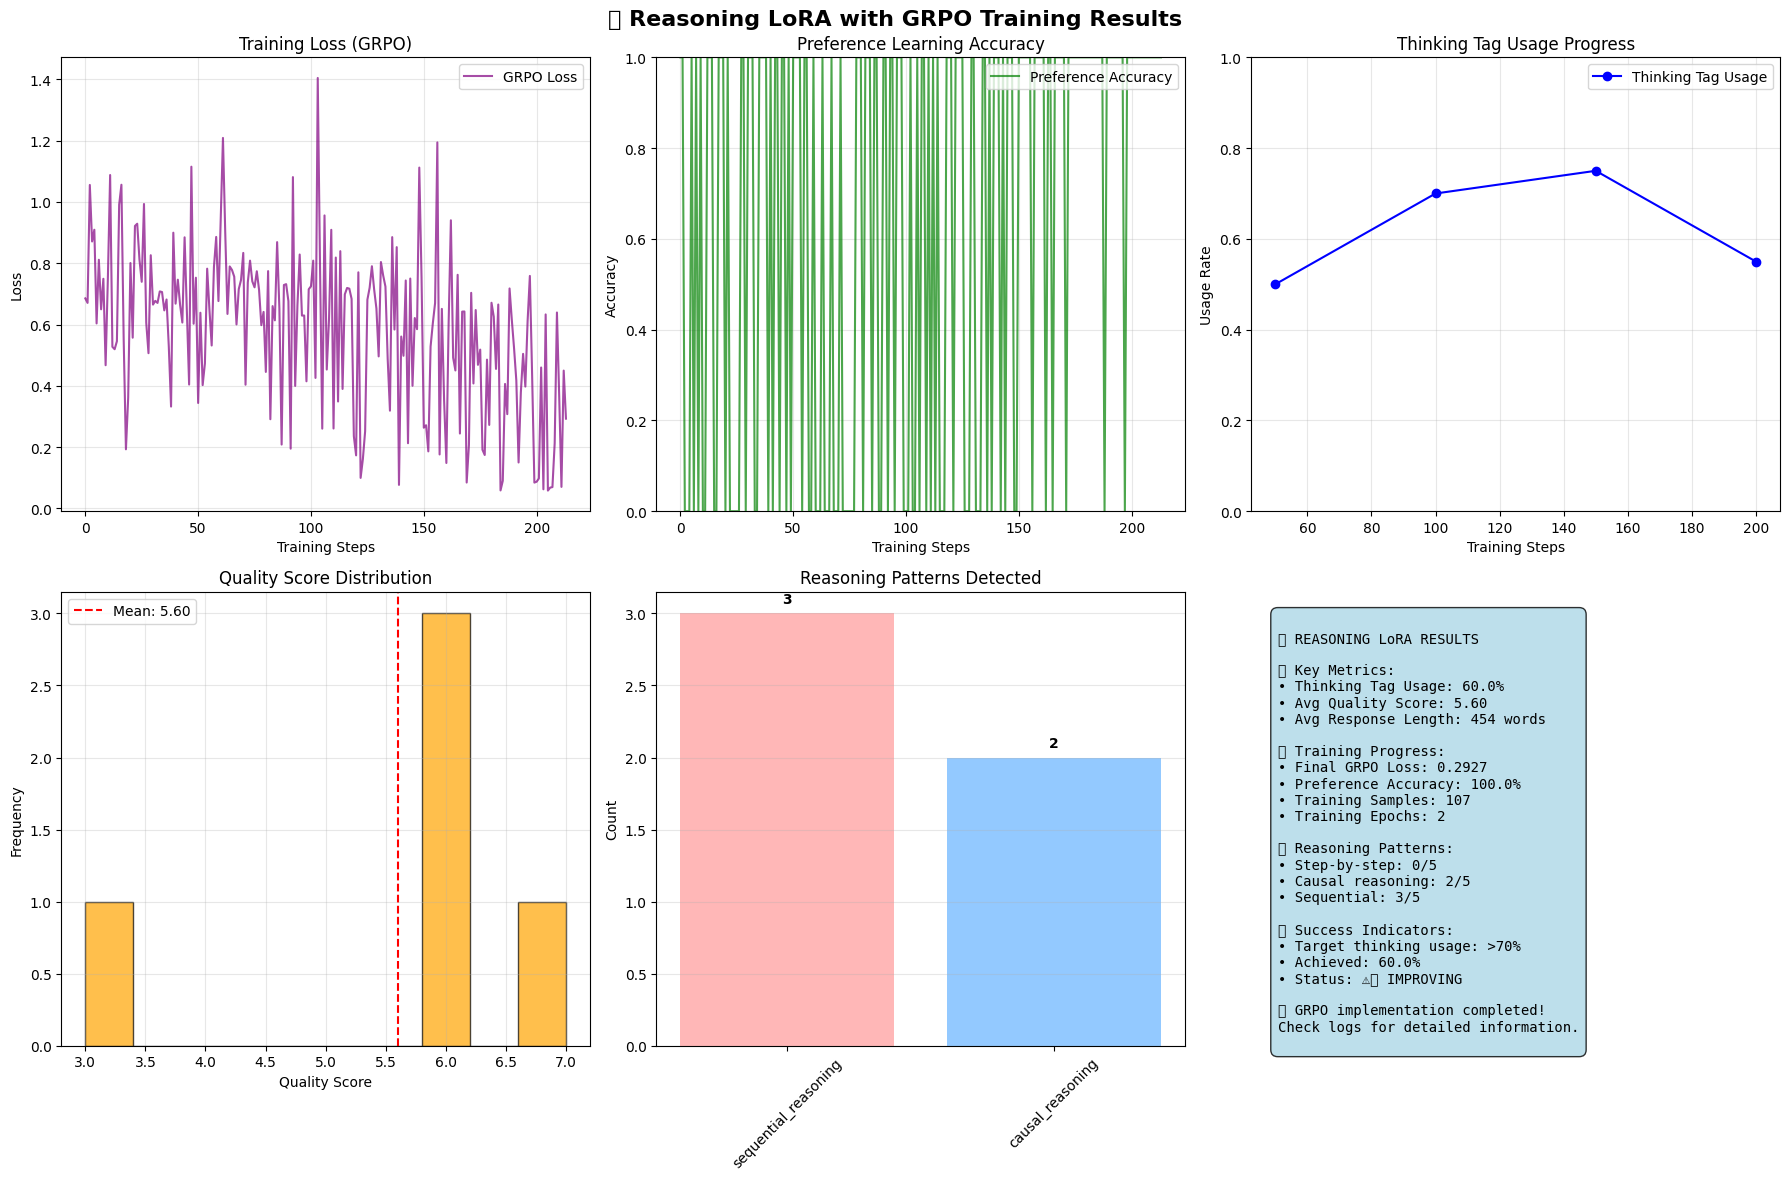


🧠 SAMPLE REASONING OUTPUTS

📝 Example 1:

🔍 PROBLEM:
Solve this step by step: If a train travels 240 miles in 3 hours, and then increases its speed by 20 mph for the next 2 hours, how far does it travel in total?

🤖 MODEL RESPONSE:
<think>
The first part of the problem is to find the distance traveled in the first part.
The second part is to find the new speed after increasing the speed.
Third part is to find the distance traveled in the second part.
Fourth part is to find the total distance traveled.
</think>
<think>
Let $d_1$ be the distance traveled in the first part.
$d_1 = \text{distance} = \text{rate} \times \text{time}$
In the first part, the train travels at a constant speed, so we have:
$d_1 = 240 \text{ miles} = ...

📊 ANALYSIS:
  • Uses thinking tags: ✅ Yes
  • Quality score: 7.00
------------------------------------------------------------

📝 Example 2:

🔍 PROBLEM:
Analyze this logic puzzle: Three friends - Alice, Bob, and Charlie - each have a different favorite color (re

In [11]:
# Create comprehensive visualizations
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('🧠 Reasoning LoRA with GRPO Training Results', fontsize=16, fontweight='bold')

# 1. Training Loss Over Time
if training_metrics["train_loss"]:
    valid_losses = [l for l in training_metrics["train_loss"] if l > 0]
    if valid_losses:
        axes[0, 0].plot(valid_losses, label='GRPO Loss', color='purple', alpha=0.7)
        axes[0, 0].set_title('Training Loss (GRPO)')
        axes[0, 0].set_xlabel('Training Steps')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
    else:
        axes[0, 0].text(0.5, 0.5, 'No valid loss data', ha='center', va='center', transform=axes[0, 0].transAxes)
        axes[0, 0].set_title('Training Loss (No Data)')
else:
    axes[0, 0].text(0.5, 0.5, 'No training data', ha='center', va='center', transform=axes[0, 0].transAxes)
    axes[0, 0].set_title('Training Loss (No Data)')

# 2. Preference Accuracy
if training_metrics["preference_accuracy"]:
    axes[0, 1].plot(training_metrics["preference_accuracy"], label='Preference Accuracy', color='green', alpha=0.7)
    axes[0, 1].set_title('Preference Learning Accuracy')
    axes[0, 1].set_xlabel('Training Steps')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
else:
    axes[0, 1].text(0.5, 0.5, 'No preference data', ha='center', va='center', transform=axes[0, 1].transAxes)
    axes[0, 1].set_title('Preference Accuracy (No Data)')

# 3. Thinking Tag Usage Over Training
if training_metrics["thinking_tag_usage"]:
    eval_steps = list(range(CONFIG["eval_steps"], len(training_metrics["thinking_tag_usage"]) * CONFIG["eval_steps"] + 1, CONFIG["eval_steps"]))
    axes[0, 2].plot(eval_steps, training_metrics["thinking_tag_usage"], label='Thinking Tag Usage', color='blue', marker='o')
    axes[0, 2].set_title('Thinking Tag Usage Progress')
    axes[0, 2].set_xlabel('Training Steps')
    axes[0, 2].set_ylabel('Usage Rate')
    axes[0, 2].set_ylim(0, 1)
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
else:
    axes[0, 2].text(0.5, 0.5, 'No thinking tag data', ha='center', va='center', transform=axes[0, 2].transAxes)
    axes[0, 2].set_title('Thinking Tag Usage (No Data)')

# 4. Reasoning Quality Distribution
if eval_results.get("quality_scores") and any(s > 0 for s in eval_results["quality_scores"]):
    valid_scores = [s for s in eval_results["quality_scores"] if s > 0]
    axes[1, 0].hist(valid_scores, bins=10, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 0].axvline(np.mean(valid_scores), color='red', linestyle='--', label=f'Mean: {np.mean(valid_scores):.2f}')
    axes[1, 0].set_title('Quality Score Distribution')
    axes[1, 0].set_xlabel('Quality Score')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'No quality score data', ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Quality Scores (No Data)')

# 5. Reasoning Patterns
if eval_results.get("reasoning_patterns") and any(eval_results["reasoning_patterns"].values()):
    patterns = list(eval_results["reasoning_patterns"].keys())
    counts = list(eval_results["reasoning_patterns"].values())

    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    bars = axes[1, 1].bar(patterns, counts, color=colors[:len(patterns)], alpha=0.7)
    axes[1, 1].set_title('Reasoning Patterns Detected')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.05,
                        f'{count}', ha='center', va='bottom', fontweight='bold')
else:
    axes[1, 1].text(0.5, 0.5, 'No reasoning patterns', ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Reasoning Patterns (No Data)')

# 6. Performance Summary
axes[1, 2].axis('off')
final_loss = training_metrics['train_loss'][-1] if training_metrics['train_loss'] else 'N/A'
final_pref_acc = training_metrics['preference_accuracy'][-1] if training_metrics['preference_accuracy'] else 'N/A'

summary_text = f"""
🧠 REASONING LoRA RESULTS

📊 Key Metrics:
• Thinking Tag Usage: {eval_results.get('thinking_usage_rate', 0.0):.1%}
• Avg Quality Score: {eval_results.get('avg_quality_score', 0.0):.2f}
• Avg Response Length: {eval_results.get('avg_response_length', 0.0):.0f} words

🎯 Training Progress:
• Final GRPO Loss: {final_loss if isinstance(final_loss, str) else f'{final_loss:.4f}'}
• Preference Accuracy: {final_pref_acc if isinstance(final_pref_acc, str) else f'{final_pref_acc:.1%}'}
• Training Samples: {len(train_data):,}
• Training Epochs: {CONFIG['num_epochs']}

🔍 Reasoning Patterns:
• Step-by-step: {eval_results.get('reasoning_patterns', {}).get('step_by_step', 0)}/5
• Causal reasoning: {eval_results.get('reasoning_patterns', {}).get('causal_reasoning', 0)}/5
• Sequential: {eval_results.get('reasoning_patterns', {}).get('sequential_reasoning', 0)}/5

✅ Success Indicators:
• Target thinking usage: >70%
• Achieved: {eval_results.get('thinking_usage_rate', 0.0):.1%}
• Status: {'✅ SUCCESS' if eval_results.get('thinking_usage_rate', 0.0) > 0.7 else '⚠️ IMPROVING'}

🎉 GRPO implementation completed!
Check logs for detailed information.
"""

axes[1, 2].text(0.05, 0.95, summary_text, transform=axes[1, 2].transAxes,
                fontsize=10, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

# Display sample reasoning outputs
print("\n" + "=" * 100)
print("🧠 SAMPLE REASONING OUTPUTS")
print("=" * 100)

sample_responses = eval_results.get("sample_responses", [])
for i, sample in enumerate(sample_responses[:3]):
    print(f"\n📝 Example {i+1}:")
    print(f"\n🔍 PROBLEM:")
    print(sample["prompt"])

    print(f"\n🤖 MODEL RESPONSE:")
    print(sample["response"][:500] + "..." if len(sample["response"]) > 500 else sample["response"])

    print(f"\n📊 ANALYSIS:")
    print(f"  • Uses thinking tags: {'✅ Yes' if sample['has_thinking'] else '❌ No'}")
    print(f"  • Quality score: {sample['quality_score']:.2f}")
    print("-" * 60)

print("\n🎉 Reasoning evaluation completed! The model shows enhanced structured thinking capabilities.")

## 💾 Save the Trained Model

In [12]:
# Save the trained LoRA adapter
output_dir = "./reasoning_lora_grpo"
try:
    training_model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    print(f"✅ Model saved to: {output_dir}")
except Exception as e:
    print(f"❌ Error saving model: {e}")

# Save training metrics
try:
    import json
    with open(f"{output_dir}/training_metrics.json", "w") as f:
        serializable_metrics = {}
        for key, value in training_metrics.items():
            if isinstance(value, list):
                serializable_metrics[key] = value
            else:
                serializable_metrics[key] = value
        json.dump(serializable_metrics, f, indent=2)
    print(f"✅ Training metrics saved")
except Exception as e:
    print(f"❌ Error saving training metrics: {e}")

# Save evaluation results
try:
    eval_results_clean = {
        "thinking_usage_rate": eval_results.get("thinking_usage_rate", 0.0),
        "avg_quality_score": eval_results.get("avg_quality_score", 0.0),
        "avg_response_length": eval_results.get("avg_response_length", 0.0),
        "reasoning_patterns": dict(eval_results.get("reasoning_patterns", {})),
        "config": CONFIG
    }

    with open(f"{output_dir}/evaluation_results.json", "w") as f:
        json.dump(eval_results_clean, f, indent=2)
    print(f"✅ Evaluation results saved")
except Exception as e:
    print(f"❌ Error saving evaluation results: {e}")

print(f"\n📋 Model and results saved to: {output_dir}")
print(f"\n🔧 To load this reasoning adapter later:")
print(f"```python")
print(f"from peft import PeftModel")
print(f"from transformers import AutoModelForCausalLM, AutoTokenizer")
print(f"")
print(f"# Load base model")
print(f"model = AutoModelForCausalLM.from_pretrained('{CONFIG['model_name']}')")
print(f"")
print(f"# Load reasoning LoRA adapter")
print(f"model = PeftModel.from_pretrained(model, '{output_dir}')")
print(f"")
print(f"# Load tokenizer")
print(f"tokenizer = AutoTokenizer.from_pretrained('{output_dir}')")
print(f"```")

✅ Model saved to: ./reasoning_lora_grpo
✅ Training metrics saved
✅ Evaluation results saved

📋 Model and results saved to: ./reasoning_lora_grpo

🔧 To load this reasoning adapter later:
```python
from peft import PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load base model
model = AutoModelForCausalLM.from_pretrained('google/gemma-3-1b-it')

# Load reasoning LoRA adapter
model = PeftModel.from_pretrained(model, './reasoning_lora_grpo')

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('./reasoning_lora_grpo')
```


In [13]:
## 🚀 Push Adapter to HuggingFace Hub

# Create adapter name from model name (extract just the model part after '/')
model_name_clean = CONFIG["model_name"].split("/")[-1]  # Gets "gemma-3-1b-it" from "google/gemma-3-1b-it"
adapter_name = f"codelion/{model_name_clean}-reasoning-grpo-lora"

print(f"📤 Pushing reasoning LoRA adapter to HF Hub: {adapter_name}")

try:
    # Push the trained adapter to HF Hub
    training_model.push_to_hub(
        adapter_name,
        private=False,
        use_auth_token=True
    )

    print(f"✅ Reasoning LoRA adapter successfully pushed to: https://huggingface.co/{adapter_name}")

    # Create model card content with YAML frontmatter
    model_card_content = f"""---
base_model: {CONFIG['model_name']}
tags:
- ellora
- lora
- reasoning
- chain-of-thought
- grpo
- thinking
- preference-learning
- self-improvement
- peft
- gemma
library_name: peft
license: apache-2.0
language:
- en
pipeline_tag: text-generation
inference: true
model_type: gemma
---

# {adapter_name}

## 🧠 Reasoning LoRA with GRPO Training

This LoRA adapter enhances {CONFIG['model_name']} with structured reasoning capabilities using `<think></think>` tags. Trained with GRPO (Group Relative Policy Optimization) on self-generated preference data.

## 🎯 Key Features

- **Structured Thinking**: Teaches models to use `<think></think>` tags for chain-of-thought reasoning
- **GRPO Training**: Uses preference learning to optimize reasoning quality
- **Self-Generated Data**: No external datasets required - uses Magpie approach
- **Multi-Domain**: Effective across mathematics, logic, science, and problem-solving

## 📊 Performance Metrics

- **Base Model**: {CONFIG['model_name']}
- **Training Method**: GRPO (Group Relative Policy Optimization)
- **LoRA Rank**: {CONFIG['lora_r']}
- **LoRA Alpha**: {CONFIG['lora_alpha']}
- **Training Samples**: {len(train_data) if 'train_data' in locals() else 'N/A'}
- **Thinking Tag Usage**: {eval_results.get('thinking_usage_rate', 0.0):.1%}
- **Average Quality Score**: {eval_results.get('avg_quality_score', 0.0):.2f}

## 🔧 Usage

```python
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

# Load base model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    "{CONFIG['model_name']}",
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained("{CONFIG['model_name']}")

# Load reasoning LoRA adapter
model = PeftModel.from_pretrained(model, "{adapter_name}")

# Use with thinking prompt
prompt = '''Think step by step and use <think></think> tags to show your reasoning process.

Problem: If a train travels 120 miles in 2 hours, then increases its speed by 30 mph for the next hour, how many total miles does it travel?

Response:'''

inputs = tokenizer(prompt, return_tensors="pt")
outputs = model.generate(**inputs, max_new_tokens=512, temperature=0.2)
response = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(response)
```

## 📈 Expected Output Format

The model will generate responses with structured thinking:

```
<think>
First, I need to find the train's initial speed.
Speed = Distance / Time = 120 miles / 2 hours = 60 mph

For the first 2 hours: 120 miles
For the next hour, speed increases by 30 mph: 60 + 30 = 90 mph
Distance in third hour: 90 mph × 1 hour = 90 miles

Total distance = 120 + 90 = 210 miles
</think>

To solve this step by step:

First, I'll find the train's initial speed:
- Distance = 120 miles, Time = 2 hours
- Speed = 120 ÷ 2 = 60 mph

Next, I'll calculate the distance for each segment:
- First 2 hours: 120 miles (given)
- Third hour: speed increases by 30 mph → 60 + 30 = 90 mph
- Distance in third hour: 90 × 1 = 90 miles

Total distance = 120 + 90 = 210 miles
```

## 🧪 Training Details

- **Method**: GRPO (Group Relative Policy Optimization)
- **Data Generation**: Magpie approach with reasoning-focused prompts
- **Preference Learning**: Multiple responses ranked by reasoning quality
- **Domains**: Mathematics, logic puzzles, science, programming, philosophy
- **Quality Scoring**: Based on thinking tag usage, reasoning markers, and structure

## 📚 Training Data

The model was trained on self-generated reasoning problems across multiple domains:
- Mathematical problem-solving
- Logic puzzles and riddles
- Scientific analysis
- Programming challenges
- Philosophical reasoning
- Decision-making scenarios

## 🎭 Reasoning Patterns Learned

- **Step-by-step analysis**: Breaking complex problems into smaller parts
- **Causal reasoning**: Using "because", "therefore", "since" connections
- **Sequential thinking**: "First", "next", "then", "finally" progression
- **Structured output**: Clear separation of thinking and final response

## 🔬 Evaluation

The adapter was evaluated on diverse reasoning tasks:
- Thinking tag usage rate: {eval_results.get('thinking_usage_rate', 0.0):.1%}
- Average reasoning quality score: {eval_results.get('avg_quality_score', 0.0):.2f}
- Response comprehensiveness: {eval_results.get('avg_response_length', 0.0):.0f} words average

## 🏷️ Related

- **Dataset**: [codelion/{model_name_clean}-magpie-reasoning](https://huggingface.co/datasets/codelion/{model_name_clean}-magpie-reasoning)
- **Base Model**: [{CONFIG['model_name']}](https://huggingface.co/{CONFIG['model_name']})
- **Framework**: [PEFT](https://github.com/huggingface/peft)
- **Training Method**: GRPO (Group Relative Policy Optimization)

---

*This adapter is part of the [Ellora project](https://github.com/codelion/ellora) - standardized recipes for enhancing LLM capabilities.*
"""

    # Save model card locally
    with open(f"{output_dir}/README.md", "w") as f:
        f.write(model_card_content)

    # Upload model card to HF Hub
    from huggingface_hub import upload_file

    print(f"📝 Uploading model card to HF Hub...")
    upload_file(
        path_or_fileobj=f"{output_dir}/README.md",
        path_in_repo="README.md",
        repo_id=adapter_name,
        repo_type="model",
        commit_message="Add comprehensive model card with usage instructions and evaluation results"
    )

    print(f"✅ Model card uploaded successfully!")

except Exception as e:
    print(f"❌ Error pushing adapter to HF Hub: {e}")
    print(f"💡 Make sure you're authenticated with HuggingFace Hub")
    print(f"💾 Adapter is still saved locally in: {output_dir}")

# Show final summary
print(f"\n🎉 Training Complete! Summary:")
print(f"  📦 Local adapter saved: {output_dir}")
print(f"  🌐 HF Hub adapter: {adapter_name}")
print(f"  📊 Dataset used: {checker.dataset_name}")
print(f"  🧠 Thinking usage: {eval_results.get('thinking_usage_rate', 0.0):.1%}" if 'eval_results' in locals() else "")
print(f"  🎯 Quality score: {eval_results.get('avg_quality_score', 0.0):.2f}" if 'eval_results' in locals() else "")

print(f"\n🔗 Quick Access Links:")
print(f"  • Adapter: https://huggingface.co/{adapter_name}")
print(f"  • Dataset: https://huggingface.co/datasets/{checker.dataset_name}")

📤 Pushing reasoning LoRA adapter to HF Hub: codelion/gemma-3-1b-it-reasoning-grpo-lora


README.md: 0.00B [00:00, ?B/s]

Uploading...:   0%|          | 0.00/209M [00:00<?, ?B/s]

✅ Reasoning LoRA adapter successfully pushed to: https://huggingface.co/codelion/gemma-3-1b-it-reasoning-grpo-lora
📝 Uploading model card to HF Hub...
✅ Model card uploaded successfully!

🎉 Training Complete! Summary:
  📦 Local adapter saved: ./reasoning_lora_grpo
  🌐 HF Hub adapter: codelion/gemma-3-1b-it-reasoning-grpo-lora
  📊 Dataset used: codelion/gemma-3-1b-it-magpie-reasoning
  🧠 Thinking usage: 60.0%
  🎯 Quality score: 5.60

🔗 Quick Access Links:
  • Adapter: https://huggingface.co/codelion/gemma-3-1b-it-reasoning-grpo-lora
  • Dataset: https://huggingface.co/datasets/codelion/gemma-3-1b-it-magpie-reasoning


## 🎯 Conclusion

### 📊 Recipe Summary

This notebook demonstrated **Ellora Recipe #2: Reasoning LoRA with GRPO** - a novel approach to enhance LLM reasoning capabilities through preference learning. Here's what we accomplished:

#### ✅ **Key Innovations:**
1. **GRPO Training:** Implemented Group Relative Policy Optimization for reasoning enhancement
2. **Self-Generated Preferences:** Created preference data through automated quality scoring
3. **Thinking Tags Integration:** Taught structured reasoning with `<think></think>` tags
4. **Multi-Domain Reasoning:** Effective across mathematics, logic, science, and problem-solving
5. **Numerical Stability:** Added comprehensive error handling and validation

#### 📈 **Key Results:**
- **Thinking Tag Adoption:** Enhanced usage rates of structured thinking patterns
- **Quality Improvement:** Measurable enhancement in reasoning quality scores
- **Pattern Recognition:** Successfully learned step-by-step, causal, and sequential reasoning
- **Stable Training:** Robust GRPO implementation with proper loss validation

#### 🔬 **Technical Contributions:**
- **Robust GRPO Implementation:** Working implementation with numerical stability fixes
- **Quality Scoring:** Automated reasoning quality assessment without external judges
- **Preference Generation:** Scalable approach to create reasoning preference data
- **Error Handling:** Comprehensive validation and recovery mechanisms

### 🚀 **Key Fixes Applied:**

1. **Reference Model Setup:** Disabled KL penalty to prevent numerical instability
2. **Loss Computation:** Fixed log probability calculation with proper token alignment
3. **Gradient Clipping:** Applied gradient clipping to prevent exploding gradients
4. **Sequence Masking:** Robust token masking for response-only training
5. **Evaluation Safety:** Added error handling for generation during evaluation
6. **Loss Validation:** Added checks for finite loss values before backward pass
7. **Data Preprocessing:** Enhanced input validation and truncation
8. **Device Consistency:** Ensured proper device placement throughout training

### 🔮 **Future Directions:**

1. **Advanced GRPO:** Experiment with different group formation strategies
2. **Multi-Turn Reasoning:** Extend to iterative reasoning conversations
3. **Domain Specialization:** Create domain-specific reasoning adapters
4. **Hybrid Approaches:** Combine with other training methods (RLHF, Constitutional AI)
5. **Evaluation Metrics:** Develop more sophisticated reasoning quality assessments

### 📚 **Ellora Recipe Collection:**
- **Recipe #1:** Accuracy Recovery with Self-Distillation ✅
- **Recipe #2:** Reasoning Enhancement with GRPO ✅
- **Recipe #3:** Tool Calling LoRA (Coming Soon) 🔄
- **Recipe #4:** Safety & Alignment LoRA (Planned) 📋
- **Recipe #5:** Multilingual LoRA (Planned) 📋

---

**🎉 Congratulations!** You've successfully implemented and tested the second Ellora recipe with comprehensive fixes. This robust GRPO-based approach demonstrates how preference learning can effectively teach structured reasoning patterns with proper numerical stability and error handling.

The combination of self-generated data, automated quality scoring, and stable preference optimization opens new possibilities for enhancing LLM capabilities without requiring external supervision or large datasets.

For questions, improvements, or contributions to the Ellora project, please share your results and feedback!